### Adding dots

In [2]:
import json
import cv2
import numpy as np
import base64
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

# === BASE64 IMAGE DECODING ===
def base64_to_image(base64_string):
    if base64_string.startswith("data:image"):
        base64_string = base64_string.split(",")[1]
    image_bytes = base64.b64decode(base64_string)
    np_arr = np.frombuffer(image_bytes, np.uint8)
    return cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

# === NEIGHBOR DETECTION FOR BRANCH FILTERING ===
def get_neighbors(y, x, skeleton):
    neighbors = []
    for j in range(-1, 2):
        for i in range(-1, 2):
            if j == 0 and i == 0:
                continue
            ny, nx = y + j, x + i
            if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
                if skeleton[ny, nx] > 0:
                    neighbors.append((ny, nx))
    return neighbors

def filter_regions_out_range(labeled_image, min_area, max_area):
    """
    Given a labeled image, returns a new labeled image that keeps only
    regions with area outside the range [min_area, max_area].
    """
    filtered = np.zeros_like(labeled_image)
    
    for region in regionprops(labeled_image):
        # Only keep regions with area NOT between min_area and max_area.
        if not (min_area <= region.area <= max_area):
            filtered[labeled_image == region.label] = region.label
    return filtered

# === SKELETONIZE AND EXTRACT LINE SEGMENTS ===
def extract_lines_start_end(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.inRange(gray, 50, 150)  # Threshold grey walkways

    # Skeletonization + branch pruning
    skeleton = skeletonize(mask > 0)
    labeled = label(skeleton)
    pruned = remove_small_objects(labeled, min_size=50)
    pruned = filter_regions_out_range(pruned, min_area=100, max_area=200)
    skeleton_pruned = pruned > 0

    return skeleton_pruned.astype(np.uint8)

# === PLOTTING FUNCTION (INLINE) ===
def plot_overlay_with_lines(image, skeleton, title="Overlay"):
    overlay = image.copy()
    overlay[skeleton == 1] = [0, 0, 255]  # Red skeleton lines

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# === PROCESS ONE IMAGE ===
def process_image(base64_image, show=False):
    image = base64_to_image(base64_image)
    skeleton = extract_lines_start_end(image)
    if show :
        plot_overlay_with_lines(image, skeleton, title="Walkway Skeleton & Line Segments")
    return skeleton

def checkHorizontal(referencePoint, point):
    xRef, yRef = referencePoint['x'], referencePoint['y']
    x,y = point['x'], point['y']
    if abs(xRef - x) > abs(yRef - y):
        return True
    else:
        return False
        
# === PROCESS POINTS TO STRAIGHTEN ===
def process_points(points_dict):
    refinedPoints = []
    for index, point in enumerate(points_dict):
        if index == 0:
            refinedPoints.append(point)
        else:
            referencePoint = refinedPoints[-1]
            if (index == len(points_dict) - 1):
                referencePoint2 = refinedPoints[0]
                if (checkHorizontal(referencePoint, point)):
                    newPoint = {}
                    newPoint['y'] = referencePoint['y']
                    newPoint['x'] = referencePoint2['x']
                    refinedPoints.append(newPoint)
                else:
                    newPoint = {}
                    newPoint['x'] = referencePoint['x']
                    newPoint['y'] = referencePoint2['y']
                    refinedPoints.append(newPoint)
            else:
                if (checkHorizontal(referencePoint, point)):
                    newPoint = {}
                    newPoint['y'] = referencePoint['y']
                    newPoint['x'] = point['x']
                    refinedPoints.append(newPoint)
                else:
                    newPoint = {}
                    newPoint['x'] = referencePoint['x']
                    newPoint['y'] = point['y']
                    refinedPoints.append(newPoint)

    return refinedPoints

def plottingOuterWalls(paddedImg):
    working_img= paddedImg.copy()
    gray = cv2.cvtColor(working_img, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # 2) Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3) For demonstration, pick the largest contour (or loop through all)
    if len(contours) == 0:
        print("No contours found!")
    else:
        contour = max(contours, key=cv2.contourArea)

        # Approximate polygon
        epsilon = 0.003 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Snap each edge to vertical/horizontal
        def snap_angle(p1, p2):
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            # If the edge is more vertical than horizontal, snap vertical
            if abs(dx) < abs(dy):
                return (p1[0], p1[1]), (p1[0], p2[1])
            else:
                return (p1[0], p1[1]), (p2[0], p1[1])

        snapped_pts = []
        for i in range(len(approx)):
            p1 = tuple(approx[i][0])
            p2 = tuple(approx[(i + 1) % len(approx)][0])  # next vertex, wrap around
            new_p1, new_p2 = snap_angle(p1, p2)
            snapped_pts.append(new_p1)
        # Add the last corner explicitly so the shape closes
        snapped_pts.append(snapped_pts[0])

        snapped_pts = np.array(snapped_pts, dtype=np.int32).reshape((-1, 1, 2))

        # 4) Draw snapped contour in RED on the original paddedImg
        cv2.drawContours(working_img, [snapped_pts], -1, (0, 0, 255), 2)


    # 7) Show side-by-side comparison

    plt.imshow(cv2.cvtColor(working_img, cv2.COLOR_BGR2RGB))
    plt.title("Snapped Contour (RED)")
    plt.axis("off")

    plt.show()
    return snapped_pts

def gettingElementsBoundingBox(allRegions, shapes, index, walkwayImage=None):
    regions = allRegions.get(str(index), [])
    shape = shapes.get(str(index), {})
    regionPoints = {}
    for ridx, region in enumerate(regions):
        regionType = shape.get(str(ridx), -1)
        regions = regionPoints.get(regionType, [])
        tunedPoints = process_points(region)
        # print(tunedPoints)
        # print(tunedPoints)
        pts = np.array([(int(pt['x']), int(pt['y'])) for pt in tunedPoints], dtype=np.int32)
        pts = pts.reshape((-1, 1, 2))
        # print(pts)
        regions.append(pts)
        regionPoints[regionType] = regions

    if walkwayImage is not None:
        for regionTypes in regionPoints:
            imgReference = walkwayImage.copy()
            points = regionPoints[regionTypes]
            for point in points:
                cv2.drawContours(imgReference, [point], -1, (255,255,255), thickness=2)
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(imgReference, cv2.COLOR_BGR2RGB))
            plt.title(f"Locations of {regionTypes}")
            plt.axis("off")
            plt.show()

    return regionPoints



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line

def createNewPathWithCoordinate(coord, skeleton, limit, show=False):
    """
    Takes in a coordinate (x, y) which represents the start of a new line.
    Explores in each of the 8 cardinal directions (including diagonals) up to a specified limit
    until it finds a nonzero pixel in the skeleton. Among all directions that yield a hit,
    only the shortest line is drawn (setting those pixels to 1) in a new skeleton array.
    
    Parameters:
        coord (tuple): Starting coordinate in (x, y) format.
        skeleton (np.ndarray): 2D binary image (numpy array) representing the skeleton.
        limit (int): Maximum number of pixels to search in each direction.
        
    Returns:
        new_skeleton (np.ndarray): A new binary image with only the shortest new path drawn.
        found_point (dict): Dictionary with the direction (dx, dy) and coordinate (x, y) of the shortest path,
                            or an empty dict if no path is found.
    """
    # Make a copy of the skeleton array so we don't modify the original
    new_skeleton = skeleton.copy()
    
    # Define the 8 cardinal directions (dx, dy)
    directions = [
        (0, -1),   # Up
        (0, 1),    # Down
        (-1, 0),   # Left
        (1, 0),    # Right
        (-1, -1),  # Up-Left
        (1, -1),   # Up-Right
        (-1, 1),   # Down-Left
        (1, 1)     # Down-Right
    ]
    
    found_points = {}
    height, width = new_skeleton.shape
    
    # Explore each direction from the starting coordinate
    for dx, dy in directions:
        found = None
        for i in range(1, limit + 1):
            new_x = coord[0] + dx * i
            new_y = coord[1] + dy * i
            # Check if new coordinates are within image boundaries
            if new_x < 0 or new_x >= width or new_y < 0 or new_y >= height:
                break
            # Check if this pixel in the skeleton is nonzero
            if new_skeleton[new_y, new_x] != 0:
                found = (new_x, new_y)
                break
        if found:
            found_points[(dx, dy)] = found

    # If no points were found in any direction, just return the original skeleton.
    if not found_points:
        print("No points found within the limit.")
        plt.figure(figsize=(10, 8))
        plt.imshow(new_skeleton, cmap='gray')
        plt.title("Modified Skeleton (No New Path Found)")
        plt.axis('off')
        plt.show()
        return new_skeleton, {}
    
    # Determine the shortest distance among all found points
    shortest_distance = float('inf')
    shortest_point = None
    shortest_direction = None
    
    for d, point in found_points.items():
        # Euclidean distance between coord and point
        distance = np.sqrt((point[0] - coord[0])**2 + (point[1] - coord[1])**2)
        if distance < shortest_distance:
            shortest_distance = distance
            shortest_point = point
            shortest_direction = d

    # Draw the line corresponding to the shortest found point
    # Note: skimage.draw.line expects (row0, col0, row1, col1) i.e. (y, x)
    rr, cc = line(coord[1], coord[0], shortest_point[1], shortest_point[0])
    new_skeleton[rr, cc] = 1  # Mark the new path pixels as 1

    # Plot the modified skeleton with the shortest new path
    if show:
        plt.figure(figsize=(10, 8))
        plt.imshow(new_skeleton, cmap='gray')
        plt.title("Modified Skeleton with Shortest New Path")
        plt.axis('off')
        plt.show()
    
    return new_skeleton, {shortest_direction: shortest_point}

def draw_nodes(nodes, background=None, figsize=(10, 8), marker_size=8):
    """
    Draws each coordinate in the nodes list as a red circle.
    
    Parameters:
        nodes (list of tuples): List of (x, y) coordinates.
        background (np.ndarray, optional): Background image to display (if provided).
        figsize (tuple): Figure size for the plot.
        marker_size (int): Marker size for the circles.
    """
    plt.figure(figsize=figsize)
    
    # If a background image is provided, show it.
    if background is not None:
        plt.imshow(background, cmap='gray')
    
    # Plot each node as a red circle
    for (x, y) in nodes:
        plt.plot(x, y, 'ro', markersize=marker_size)
    
    plt.title("Nodes")
    plt.axis('off')
    plt.show()

def breakThroughWalls(skeleton, blockDict, spacer= 5):
    # print(skeleton)
    # plt.imshow(skeleton)
    result = {}
    for regionTypes in blockDict:
        # print(regionTypes)
        regions = (blockDict[regionTypes])
        listRegions = []
        for region in (regions):
            workingRegion = []
            for index, coordinates in enumerate(region): 
                if index == 0:
                    workingRegion.append([coordinates[0][0], coordinates[0][1]])
                    continue
                reference = (region[index - 1][0])
                point = coordinates[0]
                if (reference[0] == point[0]):
                    # Vertical Line
                    xCoordinate = reference[0]
                    yCoordinates = [min(reference[1], point[1]) + i for i in range(abs(reference[1] - point[1]) + 1)]
                    for yCoordinate in yCoordinates:
                        if skeleton[yCoordinate, xCoordinate] == 1: 
                            if yCoordinate - spacer in yCoordinates:
                                workingRegion.append([xCoordinate, yCoordinate - spacer])
                            else:
                                workingRegion.append([xCoordinate, min(yCoordinates)])
                            if xCoordinate + spacer in yCoordinates:
                                workingRegion.append([xCoordinate, yCoordinate + spacer])
                            else:
                                workingRegion.append([xCoordinate, max(yCoordinates)])
                            break
                else:
                    # Vertical Line
                    xCoordinates = [min(reference[0], point[0]) + i for i in range(abs(reference[0] - point[0]) + 1)]
                    yCoordinate = reference[1]
                    for xCoordinate in xCoordinates:
                        if skeleton[yCoordinate, xCoordinate] == 1: 
                            if xCoordinate - spacer in xCoordinates:
                                workingRegion.append([xCoordinate - spacer, yCoordinate])
                            else:
                                workingRegion.append([min(xCoordinates), yCoordinate])
                            if xCoordinate + spacer in xCoordinates:
                                workingRegion.append([xCoordinate + spacer, yCoordinate])
                            else:
                                workingRegion.append([max(xCoordinates), yCoordinate])
                            break
                workingRegion.append([point[0], point[1]])
            # print(region)
            # print(workingRegion)
            listRegions.append(workingRegion)
        # print(listRegions)
        result[regionTypes] = listRegions
    print(result)
    return (result)

In [4]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def ensure_closed_polygon(points):
    """
    Ensure that the polygon points are converted to a list of (x, y) tuples (floats)
    and that the polygon is closed (first point equals last point).
    Points can be provided as NumPy arrays, lists, or dictionaries.
    """
    new_points = []
    for pt in points:
        if isinstance(pt, dict):
            # Convert dict with keys 'x' and 'y'
            new_pt = (float(pt["x"]), float(pt["y"]))
        elif isinstance(pt, (np.ndarray, list)):
            # Flatten if necessary and convert each coordinate to float
            new_pt = tuple(float(x) for x in pt)
        else:
            new_pt = (float(pt[0]), float(pt[1]))
        new_points.append(new_pt)
    if not np.array_equal(np.array(new_points[0]), np.array(new_points[-1])):
        new_points.append(new_points[0])
    return new_points

def create_floor_shapefile_all_features(walkway_array, outer_wall_points, tenant_dict, floor,
                                          output_dir="shapes", grid_size=1, vmin=0, vmax=3):
    """
    Creates a combined shapefile for one floor that includes:
      - Outer walls (if valid)
      - Walkways (each nonzero cell in the walkway_array becomes a square polygon)
      - Tenant blocks (each polygon from tenant_dict)
    
    Parameters:
      walkway_array: NumPy array (e.g., 379 x 600) where nonzero cells represent walkable paths.
      outer_wall_points: List or NumPy array of (x, y) coordinates for the outer wall boundary.
      tenant_dict: Dictionary mapping tenant types to a list of polygons (each polygon is a list of (x, y) coordinates).
      floor: An identifier for the floor (e.g., "L2" or an index).
      output_dir: Directory to save the shapefile.
      grid_size: Size of each cell in coordinate units.
      vmin, vmax: (Used for consistent plotting color range.)
    
    Returns:
      gdf: GeoDataFrame containing the combined features.
    """
    features = []
    
    # Create outer wall polygon if valid (requires at least 4 points)
    if outer_wall_points is not None and len(outer_wall_points) >= 4:
        outer_wall_points = ensure_closed_polygon(outer_wall_points)
        outer_wall_poly = Polygon(outer_wall_points)
        features.append({"feature": "outer_wall", "geometry": outer_wall_poly})
    else:
        print(f"Warning: outer_wall_points for floor {floor} has fewer than 4 points; skipping outer wall.")
    
    # Create walkway polygons: each nonzero cell becomes a square polygon.
    rows, cols = walkway_array.shape
    for i in range(rows):
        for j in range(cols):
            if walkway_array[i, j] == 0:
                continue  # Skip background cells
            poly = Polygon([
                (j * grid_size, i * grid_size),
                ((j + 1) * grid_size, i * grid_size),
                ((j + 1) * grid_size, (i + 1) * grid_size),
                (j * grid_size, (i + 1) * grid_size)
            ])
            features.append({"feature": "walkway", "geometry": poly, "value": walkway_array[i, j]})
    
    # Create tenant polygons:
    for tenant_type, poly_list in tenant_dict.items():
        for coords in poly_list:
            if len(coords) < 3:
                continue
            # Ensure the polygon is closed
            coords = ensure_closed_polygon(coords)
            tenant_poly = Polygon(coords)
            features.append({"feature": "tenant", "tenant_type": tenant_type, "geometry": tenant_poly})
    
    # Create GeoDataFrame (using pixel/grid coordinates, so no CRS is set)
    gdf = gpd.GeoDataFrame(features)
    # Clean geometries (buffer(0) fixes minor artifacts)
    gdf["geometry"] = gdf["geometry"].buffer(0)
    
    os.makedirs(output_dir, exist_ok=True)
    shp_path = os.path.join(output_dir, f"floor_{floor}_combined.shp")
    gdf.to_file(shp_path)
    print(f"Shapefile saved for floor {floor}: {shp_path}")
    
    # Plot the combined features for visual verification
    fig, ax = plt.subplots(figsize=(12, 10))
    gdf.plot(column="feature", cmap="tab20", legend=True, edgecolor="black", ax=ax)
    ax.set_title(f"Combined Floor {floor} Features")
    ax.set_aspect("equal")
    ax.invert_yaxis()  # Invert y-axis if using image-based coordinates (origin at top-left)
    plt.show()
    
    return gdf

# --- Example Usage ---
# For each floor, you would call this function with:
# 1. The walkway numpy array for that floor (e.g. "working_skeleton" from your process_image())
# 2. The outer wall points (a list of (x, y) tuples from plottingOuterWalls())
# 3. The tenant blocks dictionary (from gettingElementsBoundingBox())
# 4. A floor identifier (e.g., floor index or name)

# Example:
# Suppose for floor 2 you have:
#   walkway_array_floor2, outer_wall_points_floor2, tenant_dict_floor2
# Then call:
# gdf_floor2 = create_floor_shapefile_all_features(walkway_array_floor2, outer_wall_points_floor2,
#                                                    tenant_dict_floor2, floor="2")

In [6]:
import os
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
import warnings
import pandas as pd
import matplotlib.patches as mpatches

# Suppress Shapely deprecation warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

##############################
# Helper: Ensure Polygon Closed
##############################
def ensure_closed_polygon(points):
    """
    Convert input points (which may be provided as a NumPy array, a list of lists,
    or dictionaries) to a list of (x, y) tuples of floats and ensure the polygon is closed.
    """
    new_points = []
    for pt in points:
        if isinstance(pt, dict):
            new_pt = (float(pt["x"]), float(pt["y"]))
        elif isinstance(pt, np.ndarray):
            new_pt = tuple(pt.flatten().astype(float))
        elif isinstance(pt, list):
            if len(pt) > 0 and isinstance(pt[0], (list, np.ndarray)):
                new_pt = tuple(np.array(pt[0], dtype=float))
            else:
                new_pt = tuple(float(x) for x in pt)
        else:
            new_pt = (float(pt[0]), float(pt[1]))
        new_points.append(new_pt)
    if not np.array_equal(np.array(new_points[0]), np.array(new_points[-1])):
        new_points.append(new_points[0])
    return new_points

##############################
# Function 1: Save Working Skeleton (Walkway)
##############################
def save_skeleton_shapefile(skeleton_array, floor, output_dir="shapes", grid_size=1):
    """
    Convert a NumPy array representing walkable paths (nonzero cells)
    into square polygons and save as a shapefile.
    """
    features = []
    rows, cols = skeleton_array.shape
    for i in range(rows):
        for j in range(cols):
            if skeleton_array[i, j] == 0:
                continue
            poly = Polygon([
                (j * grid_size, i * grid_size),
                ((j + 1) * grid_size, i * grid_size),
                ((j + 1) * grid_size, (i + 1) * grid_size),
                (j * grid_size, (i + 1) * grid_size)
            ])
            features.append({"feature": "walkway", "geometry": poly, "value": int(skeleton_array[i, j])})
    
    if features:
        gdf = gpd.GeoDataFrame(features)
        gdf["geometry"] = gdf["geometry"].buffer(0)
        os.makedirs(output_dir, exist_ok=True)
        out_path = os.path.join(output_dir, f"floor_{floor}_skeleton.shp")
        gdf.to_file(out_path)
        print(f"Skeleton shapefile saved for floor {floor}: {out_path}")
        # Optional plot
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(column="feature", cmap="tab20", legend=True, edgecolor="black", ax=ax)
        ax.set_title(f"Floor {floor} - Walkway Skeleton")
        ax.set_aspect("equal")
        ax.invert_yaxis()
        plt.show()
    else:
        print(f"No walkway features found for floor {floor}.")

##############################
# Function 2: Save Outer Wall Shapefile
##############################
def save_outerwall_shapefile(outer_wall_points, floor, output_dir="shapes"):
    """
    Convert outer wall points into a Polygon and save as a shapefile.
    """
    if outer_wall_points is not None and len(outer_wall_points) >= 4:
        cleaned_outer = ensure_closed_polygon(outer_wall_points)
        try:
            outer_poly = Polygon(cleaned_outer)
        except Exception as e:
            print(f"Error creating outer wall polygon for floor {floor}: {e}")
            return
        if outer_poly.is_valid:
            gdf = gpd.GeoDataFrame([{"feature": "outer_wall", "geometry": outer_poly}])
            gdf["geometry"] = gdf["geometry"].buffer(0)
            os.makedirs(output_dir, exist_ok=True)
            out_path = os.path.join(output_dir, f"floor_{floor}_outerwall.shp")
            gdf.to_file(out_path)
            print(f"Outer wall shapefile saved for floor {floor}: {out_path}")
            # Optional plot
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(column="feature", cmap="tab20", legend=True, edgecolor="black", ax=ax)
            ax.set_title(f"Floor {floor} - Outer Wall")
            ax.set_aspect("equal")
            ax.invert_yaxis()
            plt.show()
        else:
            print(f"Outer wall polygon for floor {floor} is invalid.")
    else:
        print(f"Not enough outer wall points for floor {floor}.")

##############################
# Function 3: Save BlockDict (Tenant, Toilet, Staircase, Empty Areas) Shapefile
##############################
def save_blockdict_shapefile(block_dict, floor, output_dir="shapes"):
    """
    Process the block dictionary into polygons and save as a shapefile.
    Here, block_dict keys indicate:
      0: empty areas, 1: tenant, 2: toilet, 3: staircase.
    """
    # Map keys to feature type names.
    type_map = {0: "empty_area", 1: "tenant", 2: "toilet", 3: "staircase"}
    features = []
    for key, poly_list in block_dict.items():
        feature_type = type_map.get(int(key), f"unknown_{key}")
        for coords in poly_list:
            if len(coords) < 3:
                continue
            cleaned_coords = ensure_closed_polygon(coords)
            try:
                poly = Polygon(cleaned_coords)
            except Exception as e:
                print(f"Error creating polygon for {feature_type} on floor {floor}: {e}")
                continue
            features.append({"feature": feature_type, "geometry": poly})
    
    if features:
        gdf = gpd.GeoDataFrame(features)
        gdf["geometry"] = gdf["geometry"].buffer(0)
        os.makedirs(output_dir, exist_ok=True)
        out_path = os.path.join(output_dir, f"floor_{floor}_blockdict.shp")
        gdf.to_file(out_path)
        print(f"BlockDict shapefile saved for floor {floor}: {out_path}")
        
        # Fixed color mapping for consistent visualization across floors.
        color_mapping = {
            "empty_area": "#A7A7A7",
            "tenant": "#CAC1B8",
            "toilet": "#B4CCCE",
            "staircase": "#ACA7A1"
        }
        fixed_categories = ["empty_area", "tenant", "toilet", "staircase"]
        gdf["feature"] = pd.Categorical(gdf["feature"], categories=fixed_categories, ordered=True)
        gdf["color"] = gdf["feature"].map(color_mapping)
        
        fig, ax = plt.subplots(figsize=(12, 10))
        patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
        ax.legend(handles=patches, title="Feature Types")
        gdf.plot(color=gdf["color"], edgecolor="black", ax=ax)
        ax.set_title(f"Floor {floor} - BlockDict Features")
        ax.set_aspect("equal")
        ax.invert_yaxis()
        plt.show()
    else:
        print(f"No block_dict features found for floor {floor}.")


--- Image 0 ---


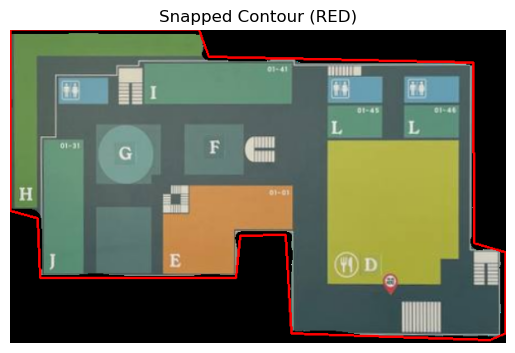

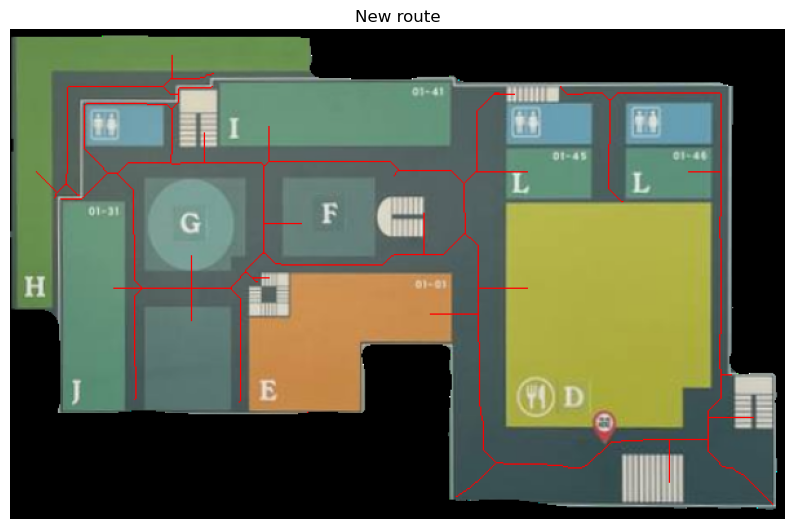

{1: [[[232, 32], [115, 32], [135, 32], [33, 32], [33, 113], [33, 133], [33, 215], [6, 215], [6, 4], [232, 4]], [[39, 132], [88, 132], [88, 190], [88, 295], [88, 295], [39, 295]], [[103, 214], [130, 214], [150, 214], [172, 214], [172, 294], [103, 294]], [[182, 115], [182, 175], [172, 175], [172, 187], [130, 187], [150, 187], [104, 187], [104, 115]], [[211, 114], [282, 114], [282, 176], [211, 176]], [[162, 42], [341, 42], [341, 90], [190, 90], [210, 90], [162, 90]], [[342, 188], [342, 210], [342, 242], [342, 242], [272, 242], [272, 294], [185, 294], [185, 222], [216, 222], [216, 188]], [[383, 134], [543, 134], [543, 278], [522, 278], [522, 308], [383, 308]], [[476, 89], [544, 89], [544, 100], [544, 131], [544, 131], [476, 131]], [[451, 90], [381, 90], [381, 100], [381, 134], [381, 134], [451, 134]]], 2: [[[119, 91], [119, 60], [60, 60], [60, 91]], [[382, 90], [452, 90], [452, 56], [382, 56]], [[476, 56], [476, 89], [544, 89], [544, 56]]], 3: [[[160, 46], [131, 46], [131, 92], [140, 92], 

/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


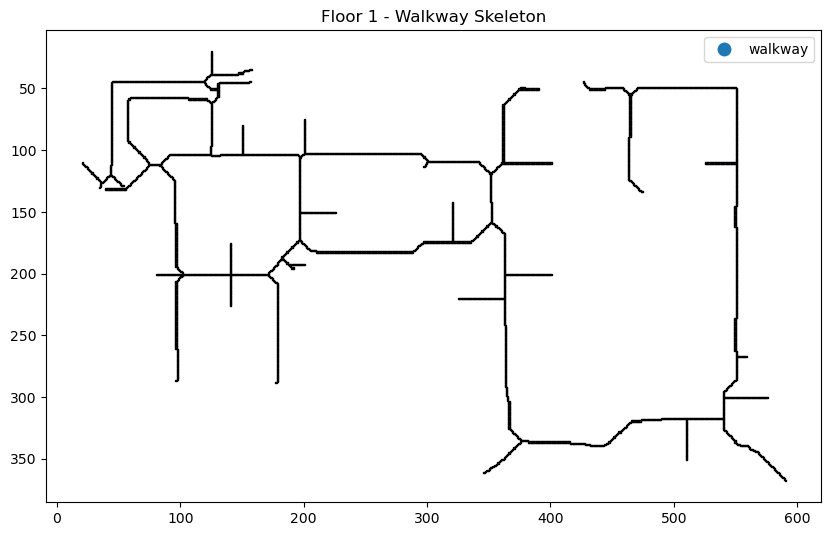

Saving outer wall shapefile...
Outer wall shapefile saved for floor 1: shapes/floor_1_outerwall.shp


/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


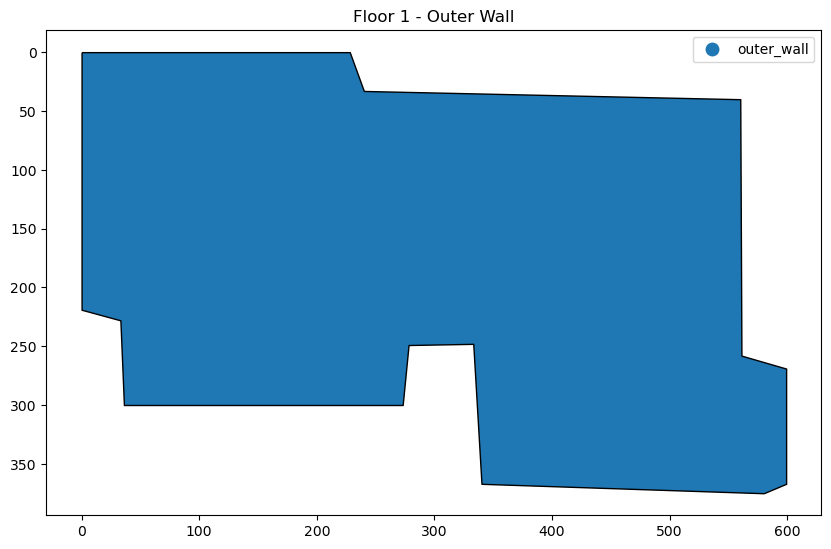

Saving block dictionary shapefile...
BlockDict shapefile saved for floor 1: shapes/floor_1_blockdict.shp


/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


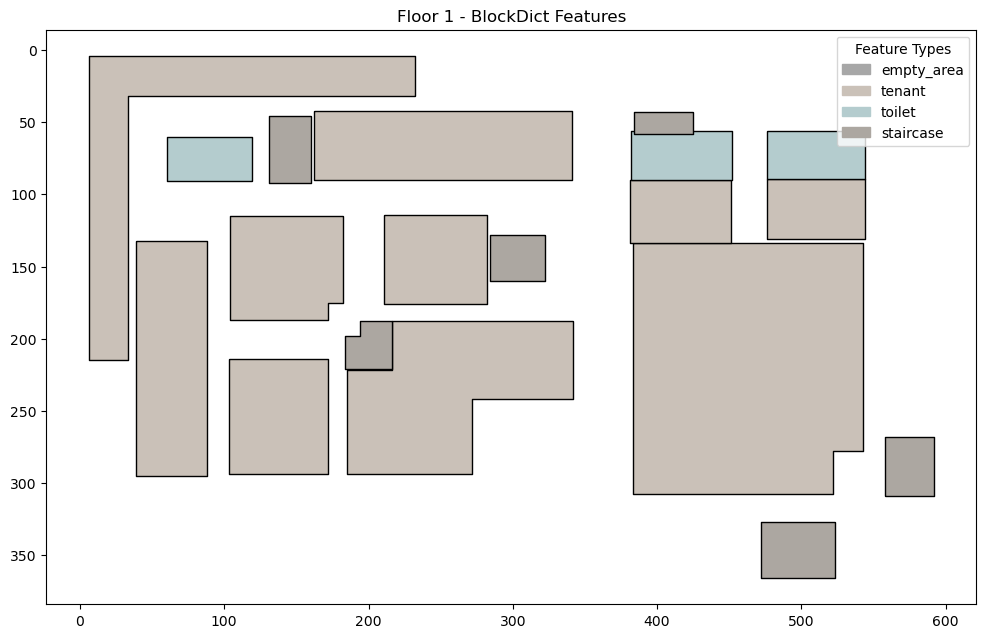

/var/folders/j4/d57x4vfd5wsdscjj243c7zs80000gn/T/ipykernel_23270/4089256103.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


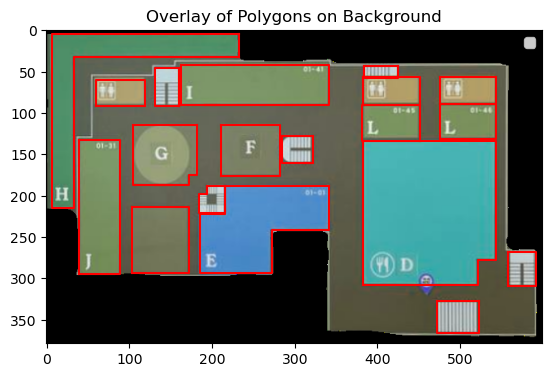


--- Image 1 ---


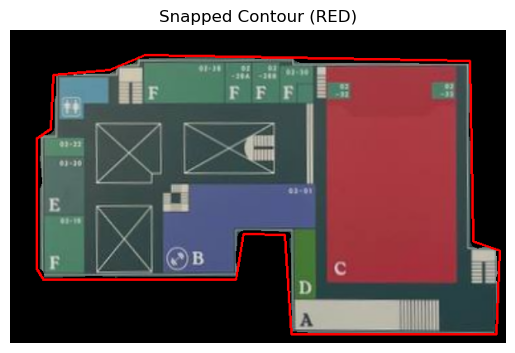

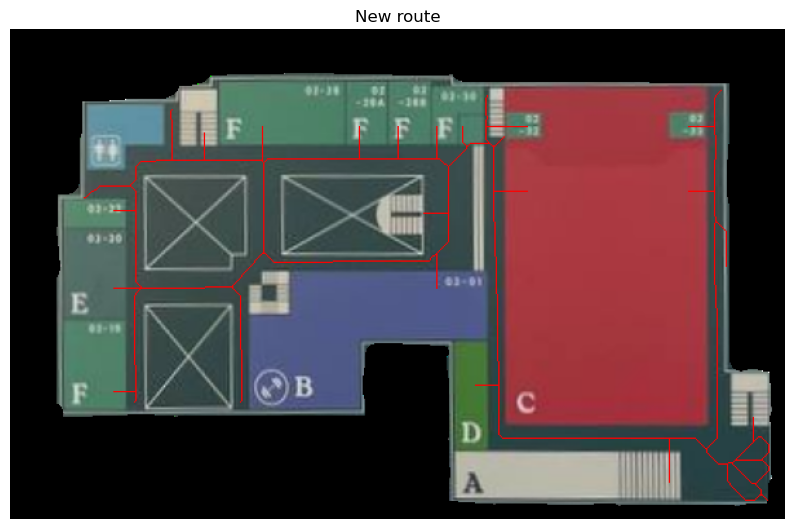

{3: [[[520, 327], [500, 327], [520, 327], [344, 327], [344, 364], [520, 364]], [[557, 307], [565, 307], [585, 307], [588, 307], [588, 266], [557, 266]], [[194, 196], [194, 186], [216, 186], [216, 221], [185, 221], [185, 196]], [[130, 90], [140, 90], [160, 90], [161, 90], [161, 46], [130, 46]], [[320, 128], [284, 128], [284, 158], [320, 158]], [[371, 46], [383, 46], [383, 65], [383, 82], [383, 82], [371, 82]]], 1: [[[370, 240], [343, 240], [343, 326], [370, 326]], [[368, 184], [320, 184], [340, 184], [216, 184], [216, 221], [184, 221], [184, 294], [272, 294], [272, 241], [368, 241]], [[90, 225], [40, 225], [40, 295], [90, 295]], [[90, 224], [42, 224], [42, 153], [90, 153]], [[90, 153], [90, 132], [90, 153], [90, 132], [40, 132], [40, 153]], [[384, 46], [538, 46], [538, 62], [510, 62], [510, 86], [538, 86], [538, 115], [538, 306], [538, 306], [386, 306], [386, 115], [386, 306], [386, 84], [410, 84], [410, 65], [384, 65]], [[537, 62], [510, 62], [510, 86], [537, 86]], [[410, 65], [385, 65

/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


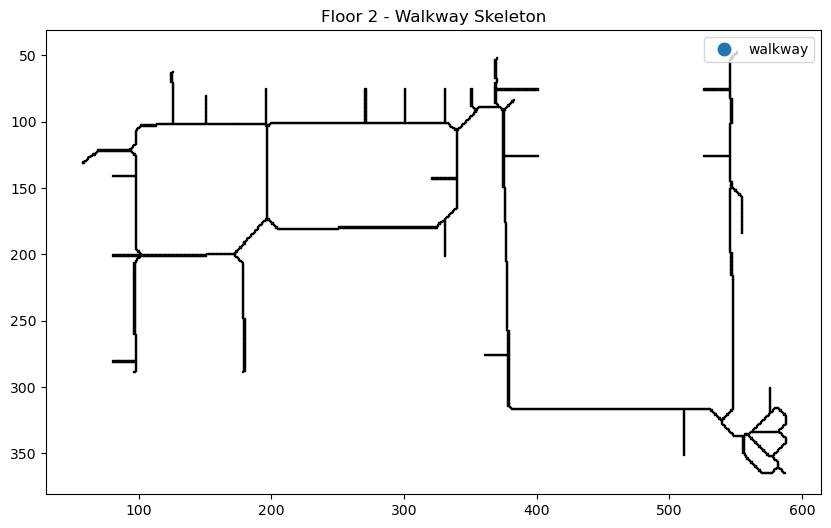

/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saving outer wall shapefile...
Outer wall shapefile saved for floor 2: shapes/floor_2_outerwall.shp


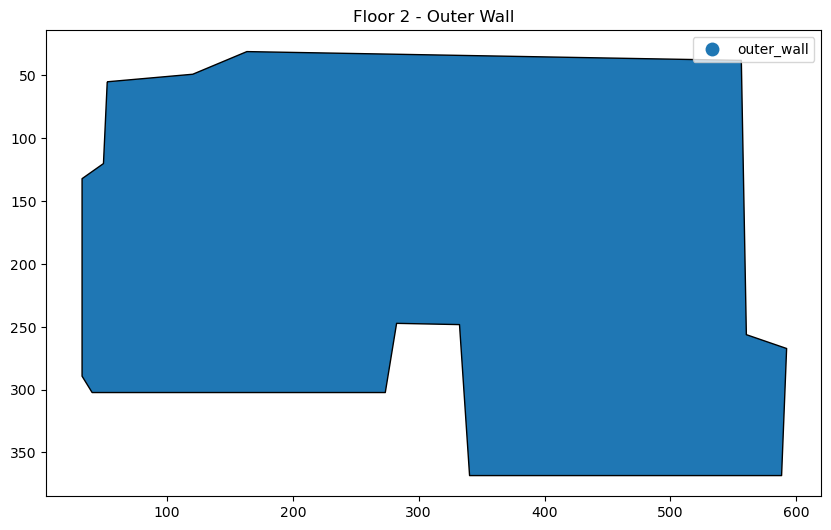

Saving block dictionary shapefile...
BlockDict shapefile saved for floor 2: shapes/floor_2_blockdict.shp


/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


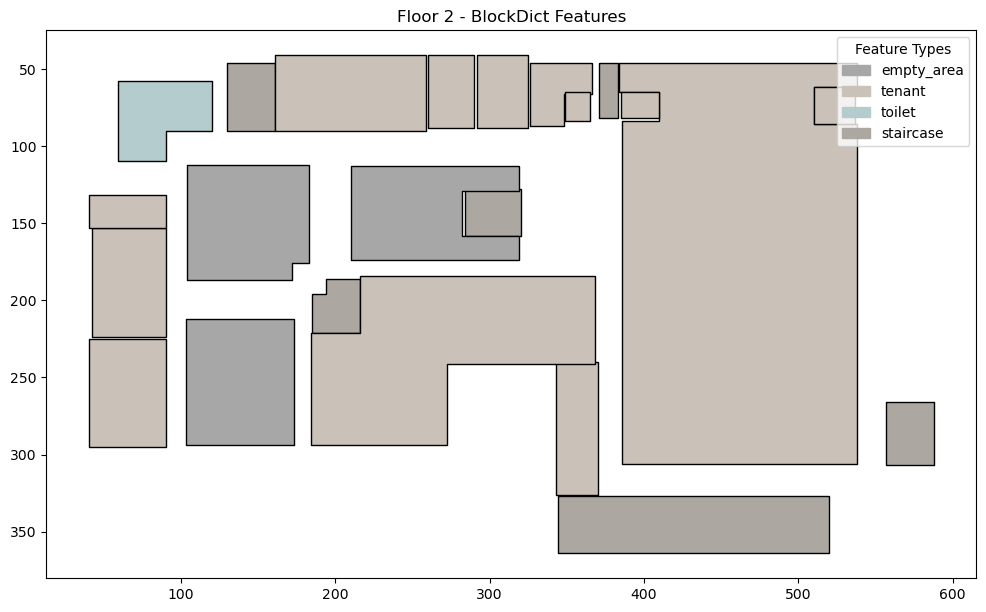

/var/folders/j4/d57x4vfd5wsdscjj243c7zs80000gn/T/ipykernel_23270/4089256103.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


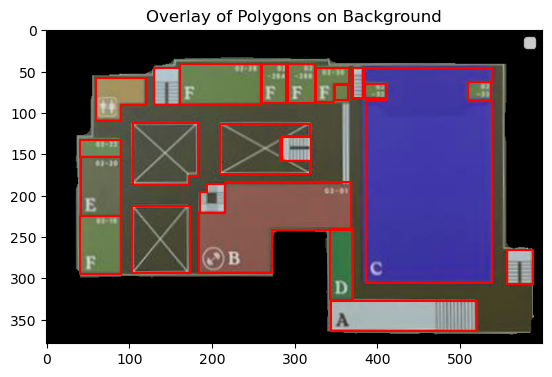


--- Image 2 ---


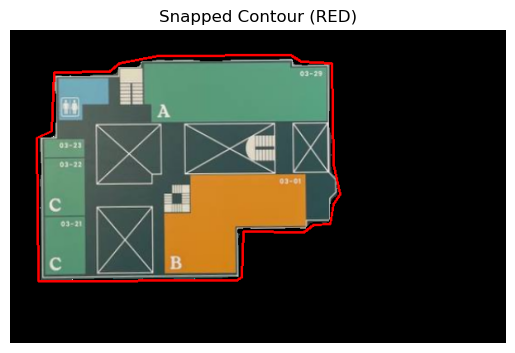

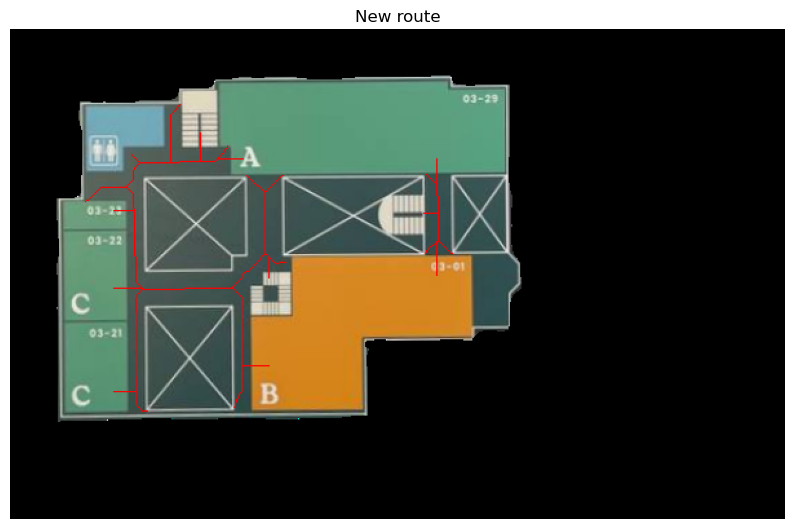

{1: [[[274, 294], [274, 240], [358, 240], [358, 174], [320, 174], [340, 174], [218, 174], [218, 222], [186, 222], [186, 250], [186, 294], [186, 294]], [[91, 226], [39, 226], [39, 297], [91, 297]], [[90, 224], [90, 190], [90, 224], [90, 155], [40, 155], [40, 224]], [[90, 156], [40, 156], [40, 134], [90, 134]], [[160, 90], [160, 90], [170, 90], [170, 90], [170, 90], [170, 112], [170, 112], [312, 112], [332, 112], [384, 112], [384, 44], [341, 44], [341, 38], [160, 38]]], 3: [[[218, 186], [218, 222], [187, 222], [187, 198], [196, 198], [196, 186]], [[320, 126], [283, 126], [283, 158], [320, 158]], [[131, 91], [137, 91], [157, 91], [160, 91], [160, 48], [131, 48]]], 0: [[[172, 214], [172, 294], [106, 294], [106, 214]], [[172, 186], [172, 176], [184, 176], [184, 114], [184, 176], [184, 114], [174, 114], [184, 114], [102, 114], [102, 186]], [[211, 114], [321, 114], [321, 127], [284, 127], [284, 158], [320, 158], [320, 173], [211, 173]], [[342, 112], [385, 112], [385, 172], [342, 172]]], 2: [[

/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


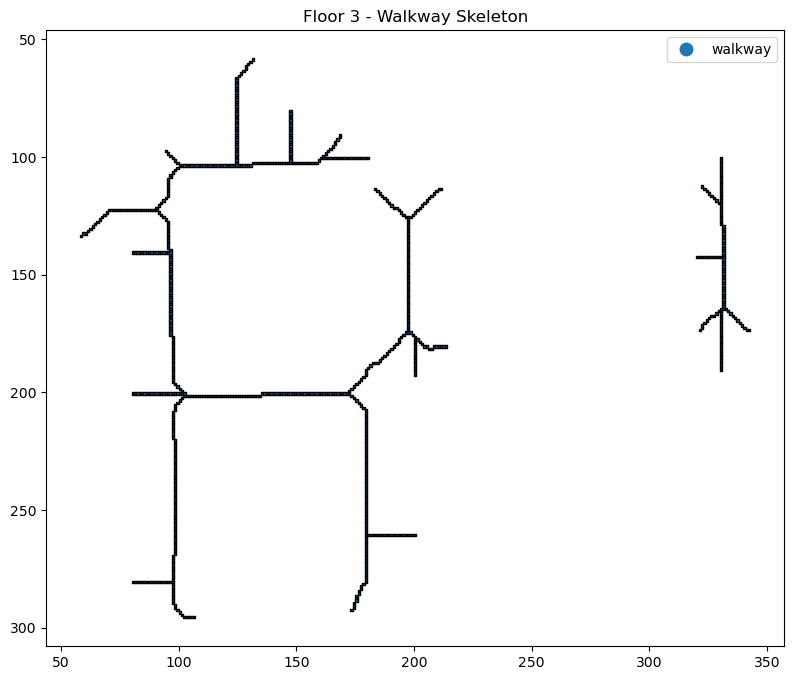

Saving outer wall shapefile...
Outer wall shapefile saved for floor 3: shapes/floor_3_outerwall.shp


/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


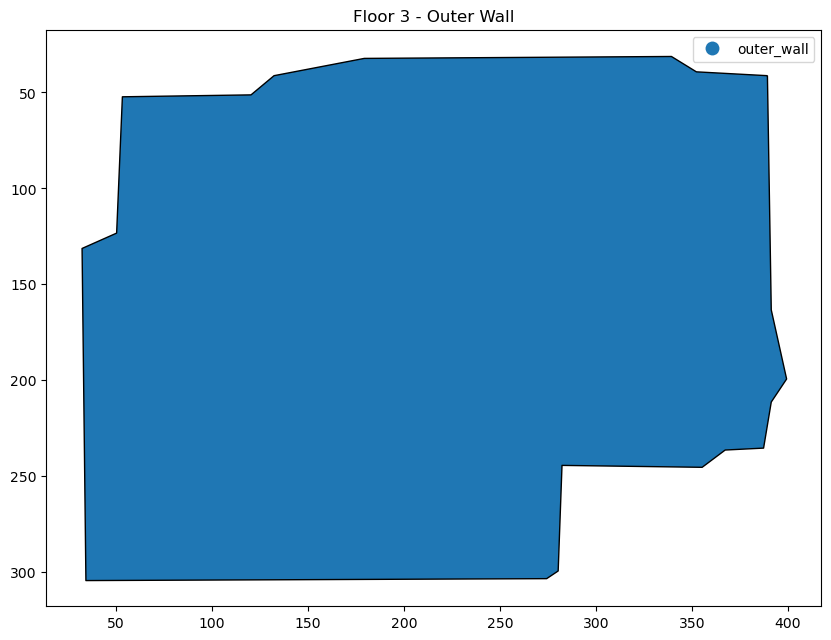

/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saving block dictionary shapefile...
BlockDict shapefile saved for floor 3: shapes/floor_3_blockdict.shp


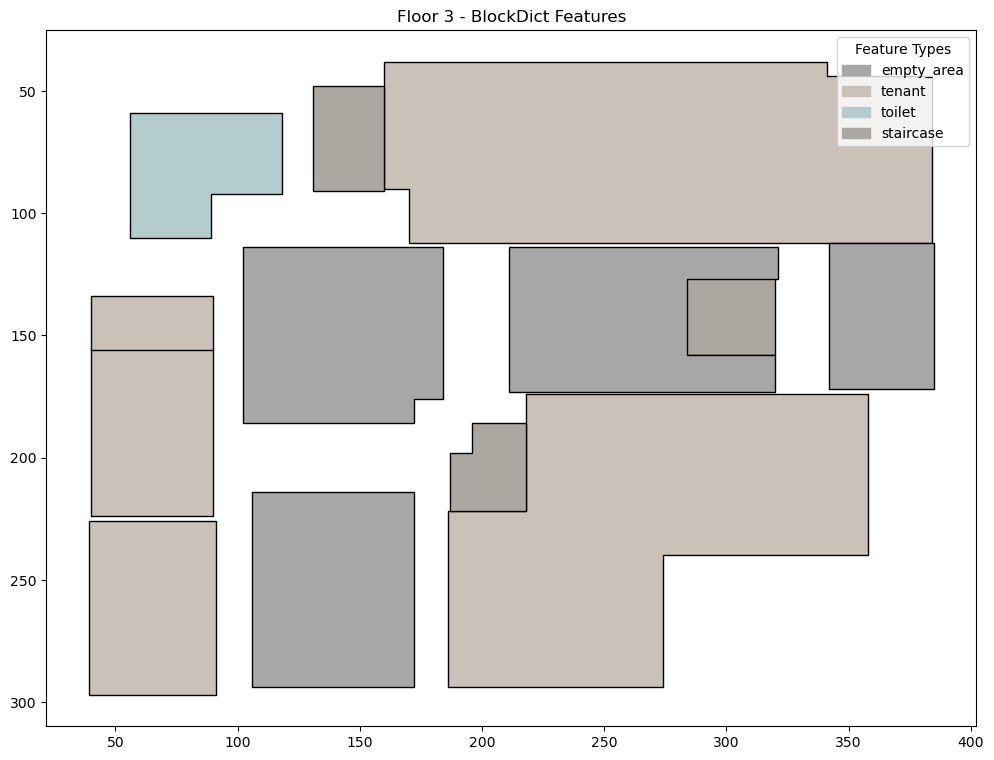

/var/folders/j4/d57x4vfd5wsdscjj243c7zs80000gn/T/ipykernel_23270/4089256103.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


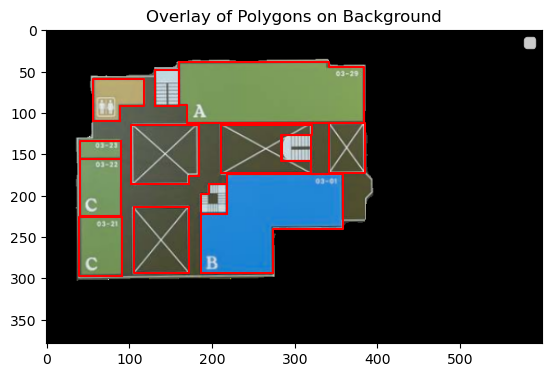


--- Image 3 ---


/var/folders/j4/d57x4vfd5wsdscjj243c7zs80000gn/T/ipykernel_23270/3497911674.py:51: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  pruned = remove_small_objects(labeled, min_size=50)


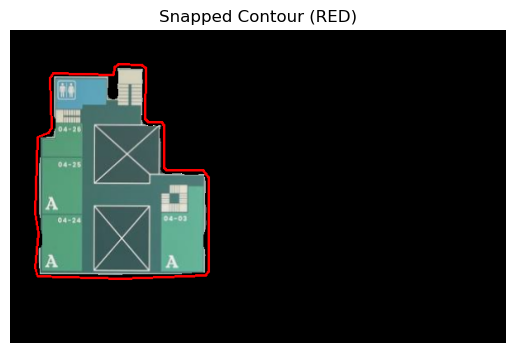

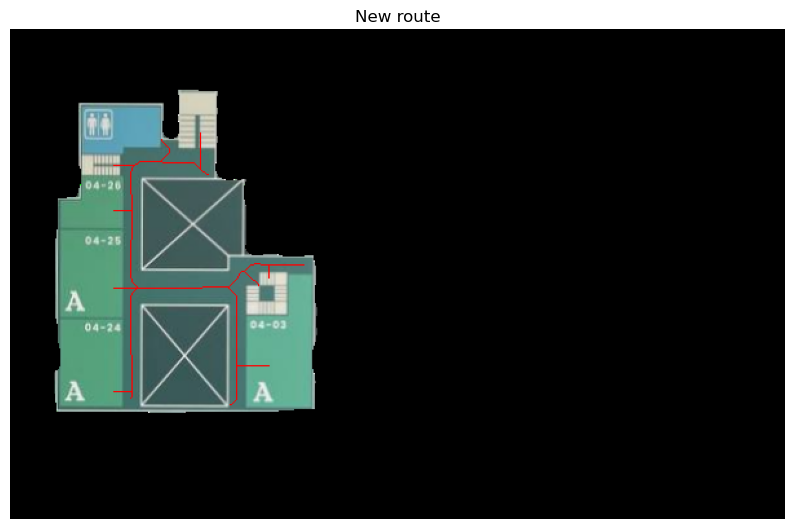

{3: [[[192, 188], [192, 188], [210, 188], [214, 188], [214, 220], [182, 220], [182, 200], [192, 200]], [[85, 112], [54, 112], [54, 97], [85, 97]], [[130, 92], [137, 92], [157, 92], [160, 92], [160, 48], [130, 48]]], 1: [[[215, 189], [234, 189], [234, 294], [182, 294], [182, 250], [182, 294], [182, 221], [215, 221]], [[86, 224], [38, 224], [38, 292], [86, 292]], [[86, 224], [38, 224], [38, 156], [86, 156]], [[87, 155], [87, 130], [87, 155], [87, 114], [55, 114], [55, 130], [36, 130], [36, 155]]], 0: [[[169, 214], [102, 214], [102, 292], [169, 292]], [[102, 116], [102, 187], [168, 187], [168, 175], [182, 175], [182, 116]]], 2: [[[86, 98], [55, 98], [55, 60], [117, 60], [117, 75], [117, 89], [117, 89], [86, 89]]]}
{3: [[[192, 188], [192, 188], [210, 188], [214, 188], [214, 220], [182, 220], [182, 200], [192, 200]], [[85, 112], [54, 112], [54, 97], [85, 97]], [[130, 92], [137, 92], [157, 92], [160, 92], [160, 48], [130, 48]]], 1: [[[215, 189], [234, 189], [234, 294], [182, 294], [182, 250]

/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


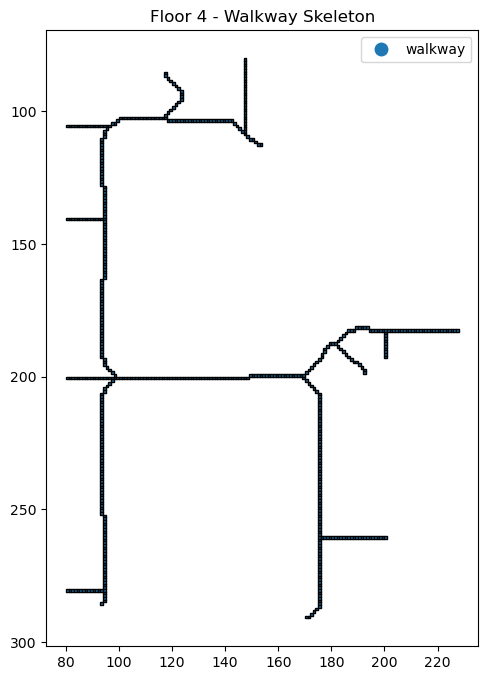

Saving outer wall shapefile...
Outer wall shapefile saved for floor 4: shapes/floor_4_outerwall.shp


/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


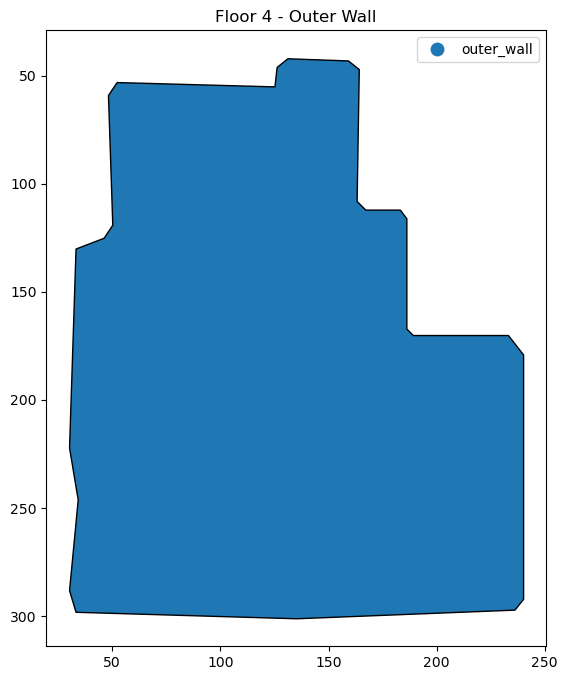

Saving block dictionary shapefile...
BlockDict shapefile saved for floor 4: shapes/floor_4_blockdict.shp


/Users/huiningonn/anaconda3/envs/waste_sim/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


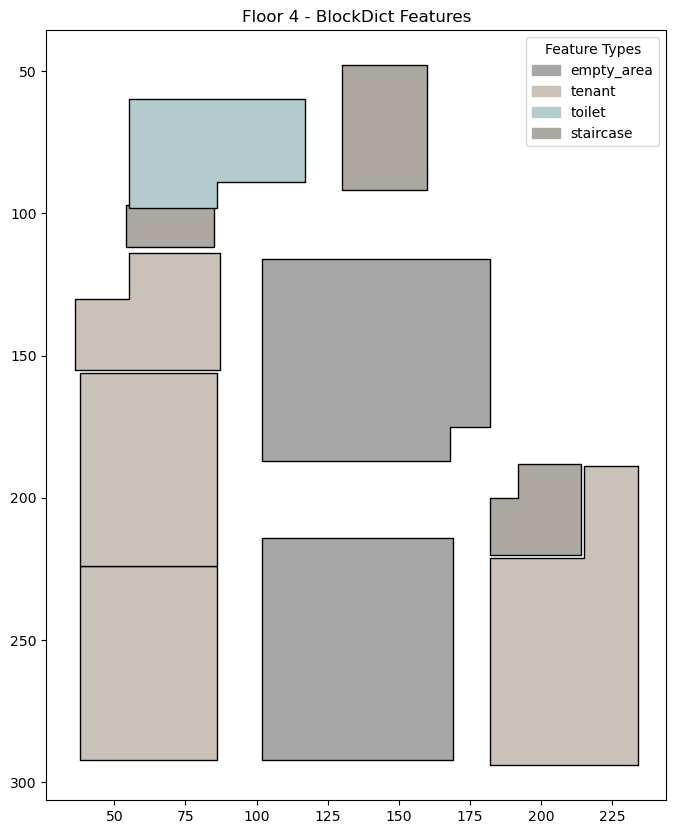

/var/folders/j4/d57x4vfd5wsdscjj243c7zs80000gn/T/ipykernel_23270/4089256103.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


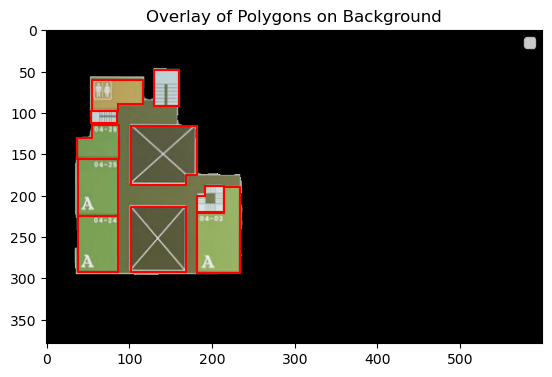

In [9]:
# === MAIN LOOP ===
with open("data.json") as f:
    """
    This contains the data that can be plotted for the shape file

    working_skeleton (numpy array) : a numpy array paths for the paths that can be used by the agents 1 represents path
    outerWallPoints (list) :  a list of coordinates to plot the outer limit walls
    blockDict (dict): a dictionary containing the blocks for the various 

    
    """
    data = json.load(f)
    allRegions = data.get("drawnRegions", {})
    shapes = data.get("shapeLabels", {})
    # print(shapes)
    walkways = data.get("walkways", [])
    paddedImages = data.get("paddedImages", [])
    extraNodes = {0: [(20, 110), (80, 200), (125, 20), (200, 75), (140, 225),(140, 175), (225, 150), (325, 220), (400, 110), (525, 110), (400, 200),                                          (150, 80), (320, 142), (200, 192),  (390, 50),  (575, 300), (510, 350)], 
                  1: [(80, 200), (80, 280), (80, 140), (195, 75), (300, 75), (270, 75), (330, 75), (350, 75), (330, 200), (360, 275), (400, 125), (400, 75), (525, 125),(525, 75),            (150, 80), (320, 142), (575, 300), (510, 350) ],
                  2: [(80, 200), (80, 280), (80, 140), (180, 100), (330, 100), (330, 190), (200, 260),                                                                                        (147, 80), (320, 142), (200, 192)],
                  3: [(80, 200), (80, 280), (80, 140), (200, 260),                                                                                       (80, 105), (147, 80), (200, 192)]
                  }

    for index, base64_img in enumerate(walkways):
        print(f"\n--- Image {index} ---")

        # Getting the agent walking path shape file (based on walkway not into shops yet)
        skeleton = process_image(base64_img)
        # print(skeleton)

        # # Getting the points of the outer wall
        paddedImg = base64_to_image(paddedImages[index])
        outerWallPoints = plottingOuterWalls(paddedImg)

        nodes = extraNodes.get(index, [])
        # draw_nodes(nodes, paddedImg)
        working_skeleton = skeleton.copy()
        for node in nodes:
            working_skeleton, _ = createNewPathWithCoordinate(node, working_skeleton, 100)
        plot_overlay_with_lines(paddedImg, working_skeleton, "New route")

        # # Getting the bouynding box for different types of land features
        walkwayImage = base64_to_image(base64_img)
        blockDict = gettingElementsBoundingBox(allRegions, shapes, index)

        # print(working_skeleton.shape)
        
        # Bursting through the walls to create a route
        coordinates = breakThroughWalls(working_skeleton, blockDict, 10)
        print(coordinates)

        processed_blockDict = {k : [arr.tolist() for arr in listed] for k, listed in blockDict.items()}

        # saving as combined shape file
        # gdf_floor = create_floor_shapefile_all_features(working_skeleton, outerWallPoints, processed_blockDict, floor=(index+1))

        # Save separate shapefiles for this floor:
        floor_id = str(index + 1)
        print("Saving skeleton shapefile...")
        save_skeleton_shapefile(working_skeleton, floor=floor_id, output_dir="shapes")
        print("Saving outer wall shapefile...")
        save_outerwall_shapefile(outerWallPoints, floor=floor_id, output_dir="shapes")
        print("Saving block dictionary shapefile...")
        save_blockdict_shapefile(processed_blockDict, floor=floor_id, output_dir="shapes")
    

        plt.imshow(paddedImg, cmap='gray', origin='upper')
        #  If your array has 3 channels (RGB), you can omit cmap='gray'

        # 2. Overlay the data
        plot_color = 'red'
        for key, blobs in coordinates.items():
            # Each 'shapes' is a list of polygons/lines
            for blob in blobs:
                # shape is a list of [x, y] points
                arr = np.array(blob)       # Convert to NumPy array for easy slicing
                xs, ys = arr[:, 0], arr[:, 1]
                # Plot with markers, lines, and optional label
                plt.plot(xs, ys, linestyle='-', color=plot_color)
                plt.plot([xs[-1], xs[0]], [ys[-1], ys[0]], linestyle='-', color=plot_color)

        # Optional: If you want to invert the y-axis to match typical image coordinates
        # (so that row 0 is at the top):
        # plt.gca().invert_yaxis()

        # Optional: If you don’t want repeated legend entries, you can manage labels differently
        plt.legend()
        plt.title("Overlay of Polygons on Background")
        plt.show()

In [ ]:
print(type(working_skeleton))
print(type(outerWallPoints))
print(type(processed_blockDict))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>


In [ ]:
print((working_skeleton))
print((outerWallPoints))
print((processed_blockDict))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[[  0   0]]

 [[  0 219]]

 [[ 33 228]]

 [[ 36 300]]

 [[273 300]]

 [[278 249]]

 [[333 248]]

 [[340 367]]

 [[580 375]]

 [[599 367]]

 [[599 269]]

 [[561 258]]

 [[560  40]]

 [[240  33]]

 [[228   0]]

 [[  0   0]]]
{1: [[[[232, 32]], [[33, 32]], [[33, 215]], [[6, 215]], [[6, 4]], [[232, 4]]], [[[39, 132]], [[88, 132]], [[88, 295]], [[39, 295]]], [[[103, 214]], [[172, 214]], [[172, 294]], [[103, 294]]], [[[182, 115]], [[182, 175]], [[172, 175]], [[172, 187]], [[104, 187]], [[104, 115]]], [[[211, 114]], [[282, 114]], [[282, 176]], [[211, 176]]], [[[162, 42]], [[341, 42]], [[341, 90]], [[162, 90]]], [[[342, 188]], [[342, 242]], [[272, 242]], [[272, 294]], [[185, 294]], [[185, 222]], [[216, 222]], [[216, 188]]], [[[383, 134]], [[543, 134]], [[543, 278]], [[522, 278]], [[522, 308]], [[383, 308]]], [[[476, 89]], [[544, 89]], [[544, 131]], [[476, 131]]], [[[451, 90]

In [ ]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
import warnings
import pandas as pd
import matplotlib.patches as mpatches

# Suppress Shapely deprecation warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

def ensure_closed_polygon(points):
    """
    Convert input points (which may be provided as a NumPy array, a list of lists,
    or dictionaries) to a list of (x, y) tuples of floats and ensure the polygon is closed.
    """
    new_points = []
    for pt in points:
        if isinstance(pt, dict):
            new_pt = (float(pt["x"]), float(pt["y"]))
        elif isinstance(pt, np.ndarray):
            # If extra dimensions exist, flatten them.
            new_pt = tuple(pt.flatten().astype(float))
        elif isinstance(pt, list):
            # If the first element is a list or array, unwrap it.
            if len(pt) > 0 and isinstance(pt[0], (list, np.ndarray)):
                new_pt = tuple(np.array(pt[0], dtype=float))
            else:
                new_pt = tuple(float(x) for x in pt)
        else:
            new_pt = (float(pt[0]), float(pt[1]))
        new_points.append(new_pt)
    if not np.array_equal(np.array(new_points[0]), np.array(new_points[-1])):
        new_points.append(new_points[0])
    return new_points

def create_floor_shapefile_all_features(walkway_array, outer_wall_points, block_dict, floor,
                                          output_dir="shapes", grid_size=1, vmin=0, vmax=3):
    """
    Creates a combined shapefile for one floor that includes:
      - Outer wall: a polygon from outer_wall_points.
      - Walkways: each nonzero cell in walkway_array becomes a square polygon.
      - Tenant blocks: Polygons for each region in block_dict, where keys denote types:
            0: empty area
            1: tenant area
            2: toilet
            3: staircase
    
    Parameters:
      walkway_array: NumPy array (e.g., 379 x 600) where nonzero cells represent walkable paths.
      outer_wall_points: List or NumPy array of points for the outer wall boundary.
      block_dict: Dictionary mapping region type keys to lists of polygons. Each polygon is a list of points.
      floor: An identifier for the floor (e.g. "2" or "L2").
      output_dir: Directory to save the shapefile.
      grid_size: Size of each cell in coordinate units.
      vmin, vmax: For consistent plotting color range.
    
    Returns:
      gdf: GeoDataFrame containing the combined features.
    """
    features = []
    
    # Process outer wall polygon if valid
    if outer_wall_points is not None and len(outer_wall_points) >= 4:
        cleaned_outer = ensure_closed_polygon(outer_wall_points)
        try:
            outer_wall_poly = Polygon(cleaned_outer)
        except Exception as e:
            print(f"Error creating outer wall polygon: {e}")
            outer_wall_poly = None
        if outer_wall_poly and outer_wall_poly.is_valid:
            features.append({"feature": "outer_wall", "geometry": outer_wall_poly})
        else:
            print(f"Warning: Outer wall polygon for floor {floor} is invalid.")
    else:
        print(f"Warning: outer_wall_points for floor {floor} has fewer than 4 points; skipping outer wall.")
    
    # Process walkway polygons: each nonzero cell becomes a square polygon.
    rows, cols = walkway_array.shape
    for i in range(rows):
        for j in range(cols):
            if walkway_array[i, j] == 0:
                continue  # Skip background cells.
            poly = Polygon([
                (j * grid_size, i * grid_size),
                ((j + 1) * grid_size, i * grid_size),
                ((j + 1) * grid_size, (i + 1) * grid_size),
                (j * grid_size, (i + 1) * grid_size)
            ])
            features.append({"feature": "walkway", "geometry": poly, "value": int(walkway_array[i, j])})
    
    # Map block_dict keys to descriptive feature types.
    type_map = {
        0: "empty_area",
        1: "tenant",
        2: "toilet",
        3: "staircase"
    }
    
    # Process tenant and other regions from block_dict.
    for key, poly_list in block_dict.items():
        feature_type = type_map.get(int(key), f"unknown_{key}")
        for coords in poly_list:
            # Each polygon may be nested; ensure it's a flat list of points.
            # We'll assume each coords is a list of points.
            if len(coords) < 3:
                continue
            cleaned_coords = ensure_closed_polygon(coords)
            try:
                region_poly = Polygon(cleaned_coords)
            except Exception as e:
                print(f"Error creating polygon for feature {feature_type}: {e}")
                continue
            features.append({"feature": feature_type, "geometry": region_poly})
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(features)
    gdf["geometry"] = gdf["geometry"].buffer(0)
    
    os.makedirs(output_dir, exist_ok=True)
    shp_path = os.path.join(output_dir, f"floor_{floor}_combined.shp")
    gdf.to_file(shp_path)
    print(f"Shapefile saved for floor {floor}: {shp_path}")

    color_mapping = {
    "outer_wall": "#EDE6D6",  
    "walkway": "#D9DBCE",
    "empty_area": "#A7A7A7",
    "tenant": "#CAC1B8", 
    "toilet": "#B4CCCE",
    "staircase": "#ACA7A1"
    }

    # Convert feature column to categorical with a fixed order:
    fixed_categories = ["outer_wall", "walkway", "empty_area", "tenant", "toilet", "staircase"]
    gdf["feature"] = pd.Categorical(gdf["feature"], categories=fixed_categories, ordered=True)
    # Create a new column for color using the fixed mapping:
    gdf["color"] = gdf["feature"].map(color_mapping)
    
    # Plot for visual verification
    fig, ax = plt.subplots(figsize=(12, 10))
    patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
    ax.legend(handles=patches, title="Feature Types")
    
    
    gdf.plot(color=gdf["color"], legend=True, edgecolor="grey", ax=ax)
    ax.set_title(f"Combined Features for Floor {floor}")
    ax.set_aspect("equal")
    ax.invert_yaxis()  # Invert y-axis if using image-based coordinates
    plt.show()
    
    return gdf

In [5]:
import os
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
import warnings
import pandas as pd
import matplotlib.patches as mpatches

# Suppress Shapely deprecation warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

##############################
# Helper: Ensure Polygon Closed
##############################
def ensure_closed_polygon(points):
    """
    Convert input points (which may be provided as a NumPy array, a list of lists,
    or dictionaries) to a list of (x, y) tuples of floats and ensure the polygon is closed.
    """
    new_points = []
    for pt in points:
        if isinstance(pt, dict):
            new_pt = (float(pt["x"]), float(pt["y"]))
        elif isinstance(pt, np.ndarray):
            new_pt = tuple(pt.flatten().astype(float))
        elif isinstance(pt, list):
            if len(pt) > 0 and isinstance(pt[0], (list, np.ndarray)):
                new_pt = tuple(np.array(pt[0], dtype=float))
            else:
                new_pt = tuple(float(x) for x in pt)
        else:
            new_pt = (float(pt[0]), float(pt[1]))
        new_points.append(new_pt)
    if not np.array_equal(np.array(new_points[0]), np.array(new_points[-1])):
        new_points.append(new_points[0])
    return new_points

##############################
# Function 1: Save Working Skeleton (Walkway)
##############################
def save_skeleton_shapefile(skeleton_array, floor, output_dir="shapes", grid_size=1):
    """
    Convert a NumPy array representing walkable paths (nonzero cells)
    into square polygons and save as a shapefile.
    """
    features = []
    rows, cols = skeleton_array.shape
    for i in range(rows):
        for j in range(cols):
            if skeleton_array[i, j] == 0:
                continue
            poly = Polygon([
                (j * grid_size, i * grid_size),
                ((j + 1) * grid_size, i * grid_size),
                ((j + 1) * grid_size, (i + 1) * grid_size),
                (j * grid_size, (i + 1) * grid_size)
            ])
            features.append({"feature": "walkway", "geometry": poly, "value": int(skeleton_array[i, j])})
    
    if features:
        gdf = gpd.GeoDataFrame(features)
        gdf["geometry"] = gdf["geometry"].buffer(0)
        os.makedirs(output_dir, exist_ok=True)
        out_path = os.path.join(output_dir, f"floor_{floor}_skeleton.shp")
        gdf.to_file(out_path)
        print(f"Skeleton shapefile saved for floor {floor}: {out_path}")
        # Optional plot
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(column="feature", cmap="tab20", legend=True, edgecolor="black", ax=ax)
        ax.set_title(f"Floor {floor} - Walkway Skeleton")
        ax.set_aspect("equal")
        ax.invert_yaxis()
        plt.show()
    else:
        print(f"No walkway features found for floor {floor}.")

##############################
# Function 2: Save Outer Wall Shapefile
##############################
def save_outerwall_shapefile(outer_wall_points, floor, output_dir="shapes"):
    """
    Convert outer wall points into a Polygon and save as a shapefile.
    """
    if outer_wall_points is not None and len(outer_wall_points) >= 4:
        cleaned_outer = ensure_closed_polygon(outer_wall_points)
        try:
            outer_poly = Polygon(cleaned_outer)
        except Exception as e:
            print(f"Error creating outer wall polygon for floor {floor}: {e}")
            return
        if outer_poly.is_valid:
            gdf = gpd.GeoDataFrame([{"feature": "outer_wall", "geometry": outer_poly}])
            gdf["geometry"] = gdf["geometry"].buffer(0)
            os.makedirs(output_dir, exist_ok=True)
            out_path = os.path.join(output_dir, f"floor_{floor}_outerwall.shp")
            gdf.to_file(out_path)
            print(f"Outer wall shapefile saved for floor {floor}: {out_path}")
            # Optional plot
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(column="feature", cmap="tab20", legend=True, edgecolor="black", ax=ax)
            ax.set_title(f"Floor {floor} - Outer Wall")
            ax.set_aspect("equal")
            ax.invert_yaxis()
            plt.show()
        else:
            print(f"Outer wall polygon for floor {floor} is invalid.")
    else:
        print(f"Not enough outer wall points for floor {floor}.")

##############################
# Function 3: Save BlockDict (Tenant, Toilet, Staircase, Empty Areas) Shapefile
##############################
def save_blockdict_shapefile(block_dict, floor, output_dir="shapes"):
    """
    Process the block dictionary into polygons and save as a shapefile.
    Here, block_dict keys indicate:
      0: empty areas, 1: tenant, 2: toilet, 3: staircase.
    """
    # Map keys to feature type names.
    type_map = {0: "empty_area", 1: "tenant", 2: "toilet", 3: "staircase"}
    features = []
    for key, poly_list in block_dict.items():
        feature_type = type_map.get(int(key), f"unknown_{key}")
        for coords in poly_list:
            if len(coords) < 3:
                continue
            cleaned_coords = ensure_closed_polygon(coords)
            try:
                poly = Polygon(cleaned_coords)
            except Exception as e:
                print(f"Error creating polygon for {feature_type} on floor {floor}: {e}")
                continue
            features.append({"feature": feature_type, "geometry": poly})
    
    if features:
        gdf = gpd.GeoDataFrame(features)
        gdf["geometry"] = gdf["geometry"].buffer(0)
        os.makedirs(output_dir, exist_ok=True)
        out_path = os.path.join(output_dir, f"floor_{floor}_blockdict.shp")
        gdf.to_file(out_path)
        print(f"BlockDict shapefile saved for floor {floor}: {out_path}")
        
        # Fixed color mapping for consistent visualization across floors.
        color_mapping = {
            "empty_area": "#A7A7A7",
            "tenant": "#CAC1B8",
            "toilet": "#B4CCCE",
            "staircase": "#ACA7A1"
        }
        fixed_categories = ["empty_area", "tenant", "toilet", "staircase"]
        gdf["feature"] = pd.Categorical(gdf["feature"], categories=fixed_categories, ordered=True)
        gdf["color"] = gdf["feature"].map(color_mapping)
        
        fig, ax = plt.subplots(figsize=(12, 10))
        patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
        ax.legend(handles=patches, title="Feature Types")
        gdf.plot(color=gdf["color"], edgecolor="black", ax=ax)
        ax.set_title(f"Floor {floor} - BlockDict Features")
        ax.set_aspect("equal")
        ax.invert_yaxis()
        plt.show()
    else:
        print(f"No block_dict features found for floor {floor}.")
